In [1]:
import pandas as pd
import ktrain
import re
import emoji

/home/j/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in data
df = pd.read_csv('/home/j/Documents/Projects/social-media-combat-detection/scripts-notebooks/annotated.csv')

df.head()

,Unnamed: 0,idx,msg_txt,annotation
0,0,0,"In Kyiv, fragments of a downed rocket damage...",1
1,1,1,"Kyiv region is attacked by drones again, air...",1
2,2,2,Explosions are also heard in the capital. Ai...,1
3,3,4,Kyiv region is attacked by drones - Kuleba ...,1
4,5,5,The rocket that fell in Shevchenkivskyi dist...,0


In [3]:
def drop_og(msg_text):
    if 'original :' in msg_text:
        return msg_text[0:msg_text.index('original :')]
    else:
        return msg_text

def remove_links(msg_text):
    return re.sub(r'http[s]?://\S+', '', msg_text)

def remove_sm_tags(msg_text):
    #return re.sub(r'\s*(@\w+|#\w+)\s*', '', msg_text)
    return re.sub(r'\s*[@#]\w+\b', '', msg_text)

def clean_emojis(x_row):
    if len(x_row.emoji_expd) != 0:
        for ed in x_row.emoji_expd:
            x_row.msg_txt = x_row.msg_txt.replace(ed,'')
    return x_row.msg_text

In [4]:
#msg text cleaning
df['msg_txt'] = df.msg_txt.apply(remove_links)
df['msg_txt'] = df.msg_txt.apply(remove_sm_tags)
df['msg_txt'] = df.msg_txt.apply(emoji.demojize)

In [26]:
combat  = df[df['annotation']==1.0]

not_combat = df[df['annotation']==0.0].sample(len(combat))

In [27]:
data_sample = pd.concat([combat, not_combat])

In [28]:
data_sample.describe()

,Unnamed: 0,idx,annotation
count,1618.000000,1618.000000,1618.000000
mean,1110.001854,1004.087145,0.500000
std,836.426796,692.810602,0.500155
min,0.000000,0.000000,0.000000
25%,443.750000,431.500000,0.000000
50%,863.500000,855.000000,0.500000
75%,1687.500000,1542.750000,1.000000
max,2999.000000,2433.000000,1.000000


## Modeling

Next, I'll load in a pre-trained transformer model. For now, I will use 'distilbert'.

In [43]:
train, val, preprocess = ktrain.text.texts_from_df(
    data_sample,
    text_column = 'msg_txt',
    label_columns = ['annotation'],
    val_df = None,
    max_features = 50000,
    maxlen = 128,
    val_pct = 0.1,
    ngram_range = 4,
    preprocess_mode = 'distilbert',
    verbose = 1
)

['not_annotation', 'annotation']
      not_annotation  annotation
1802             1.0         0.0
1326             0.0         1.0
2777             0.0         1.0
107              1.0         0.0
2375             1.0         0.0
['not_annotation', 'annotation']
      not_annotation  annotation
1143             0.0         1.0
1179             0.0         1.0
2012             0.0         1.0
1305             1.0         0.0
2105             0.0         1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 54
	95percentile : 163
	99percentile : 255


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 56
	95percentile : 146
	99percentile : 230


In [56]:
#model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=90)

In [63]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
26/26 [==============================] - 13s 149ms/step - loss: 0.7070 - accuracy: 0.3906
Epoch 2/6
26/26 [==============================] - 4s 151ms/step - loss: 0.5726 - accuracy: 0.7164
Epoch 3/6
26/26 [==============================] - 4s 148ms/step - loss: 0.5043 - accuracy: 0.7891
Epoch 4/6
26/26 [==============================] - 4s 148ms/step - loss: 0.8452 - accuracy: 0.6218
Epoch 5/6
26/26 [==============================] - 3s 118ms/step - loss: 46.9679 - accuracy: 0.6165


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


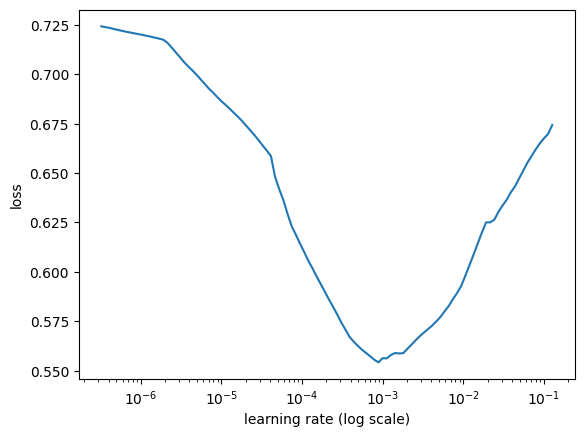

In [64]:
learner.lr_plot()

In [57]:
history=learner.autofit(lr=1e-4, epochs=10, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
17/17 [==============================] - 8s 433ms/step - loss: 0.0660 - accuracy: 0.9842 - val_loss: 0.2679 - val_accuracy: 0.9321
Epoch 2/10
17/17 [==============================] - 7s 419ms/step - loss: 0.0511 - accuracy: 0.9863 - val_loss: 0.2243 - val_accuracy: 0.9383
Epoch 3/10
17/17 [==============================] - 7s 423ms/step - loss: 0.0454 - accuracy: 0.9918 - val_loss: 0.4740 - val_accuracy: 0.8827
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [58]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [59]:
validation = learner.validate(val_data=val, print_report=True)

6/6 [==============================] - 0s 51ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        74
           1       0.94      0.94      0.94        88

    accuracy                           0.94       162
   macro avg       0.94      0.94      0.94       162
weighted avg       0.94      0.94      0.94       162



In [51]:
predictor.save('distilbert')